In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

In [2]:
data = pd.read_csv("creditcard.csv")
print(data.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 


Count of each class:
Class
0    284315
1       492
Name: count, dtype: int64


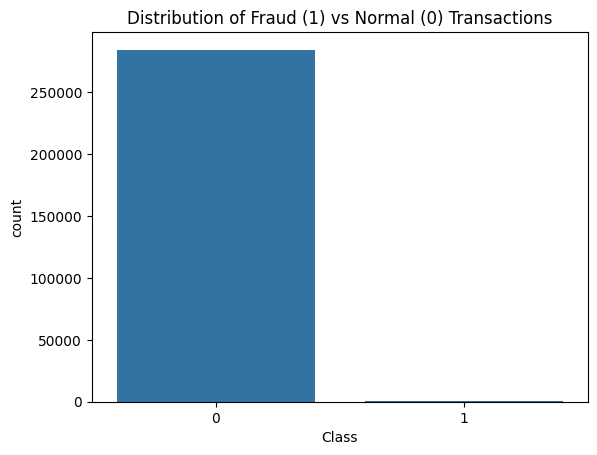

In [3]:
# 3. Count Normal vs Fraud Transactions
# -------------------------------------------------------------
print("\nCount of each class:")
print(data["Class"].value_counts())

sns.countplot(x="Class", data=data)
plt.title("Distribution of Fraud (1) vs Normal (0) Transactions")
plt.show()

In [4]:
# 4. Split Features & Labels
# -------------------------------------------------------------
X = data.drop("Class", axis=1)
y = data["Class"]

# Scale all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (keep frauds in test also)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Use ONLY normal data for training autoencoder
X_train_norm = X_train[y_train == 0]
X_test_norm  = X_test[y_test == 0]   # normal test
X_test_fraud = X_test[y_test == 1]   # fraud test

print("Normal train shape:", X_train_norm.shape)
print("Fraud test shape:", X_test_fraud.shape)


Normal train shape: (227451, 30)
Fraud test shape: (98, 30)


In [14]:
# 5. Build Autoencoder Architecture
# -------------------------------------------------------------
input_dim = X_train_norm.shape[1]
encoding_dim = 14     # compressed feature size

# Input Layer
input_layer = Input(shape=(input_dim,))

# Encoder
encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoder = Dense(encoding_dim // 2, activation="relu")(encoder)

# Decoder
decoder = Dense(encoding_dim // 2, activation="relu")(encoder)
decoder = Dense(input_dim, activation="tanh")(decoder)

# Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 14)                  │             434 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             105 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 7)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 30)                  │             240 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 835 (3.26 KB)

 Trainable params: 835 (3.26 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
autoencoder.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mse"]
)

Epoch 1/20
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.7540 - mse: 0.7504 - val_loss: 0.6886 - val_mse: 0.6857
Epoch 2/20
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.6941 - mse: 0.6913 - val_loss: 0.6699 - val_mse: 0.6670
Epoch 3/20
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.6815 - mse: 0.6786 - val_loss: 0.6629 - val_mse: 0.6599
Epoch 4/20
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.6772 - mse: 0.6742 - val_loss: 0.6599 - val_mse: 0.6568
Epoch 5/20
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.6746 - mse: 0.6715 - val_loss: 0.6569 - val_mse: 0.6537
Epoch 6/20
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.6722 - mse: 0.6689 - val_loss: 0.6552 - val_mse: 0.6519
Epoch 7/20
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.6702 - mse: 0.6669 - val_loss: 0.6526 - val_mse: 0.6492
Epoch 8/20
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.6691 - mse: 0.6657 - val_loss: 0.6518 - val_mse: 0.6484
Epoch 9/20
3554/3554 ━━━━━━━━━━━━━━━━━━━

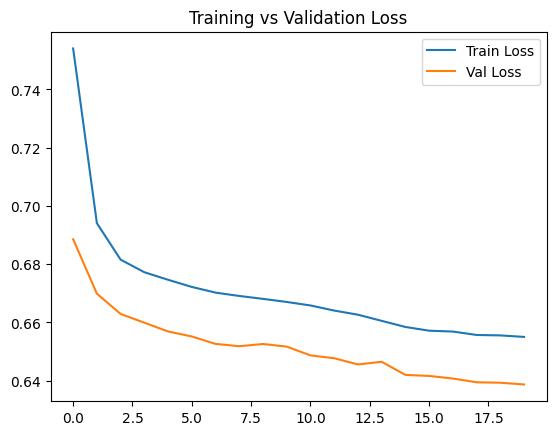

In [7]:
# 6. Train Autoencoder
# -------------------------------------------------------------
history = autoencoder.fit(
    X_train_norm, X_train_norm,
    epochs=20,
    batch_size=64,
    shuffle=True,
    validation_data=(X_test_norm, X_test_norm)
)

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [9]:
# 7. Reconstruction & Thresholding
# -------------------------------------------------------------
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

threshold = np.percentile(mse, 95)
print("Threshold:", threshold)

# Fraud if reconstruction error exceeds threshold
y_pred = [1 if e > threshold else 0 for e in mse]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, mse)
print("ROC-AUC Score:", roc_auc)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step
Threshold: 1.4470969157955682

Confusion Matrix:
[[54103  2761]
 [   10    88]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56864
           1       0.03      0.90      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.92      0.52     56962
weighted avg       1.00      0.95      0.97     56962

ROC-AUC Score: 0.9576506566329401


In [11]:
# 8. Predict a Single Sample
# -------------------------------------------------------------
sample_index = 16
sample = X_test[sample_index].reshape(1, -1)

reconstruction = autoencoder.predict(sample)
mse_sample = np.mean(np.power(sample - reconstruction, 2))

print("\nSample Index:", sample_index)
print("Reconstruction Error:", mse_sample)

if mse_sample > threshold:
    print("🔴 This transaction is FRAUD")
else:
    print("🟢 This transaction is NORMAL")

print("Actual Class:", y_test.iloc[sample_index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Sample Index: 16
Reconstruction Error: 1.0850693774350362
🟢 This transaction is NORMAL
Actual Class: 0


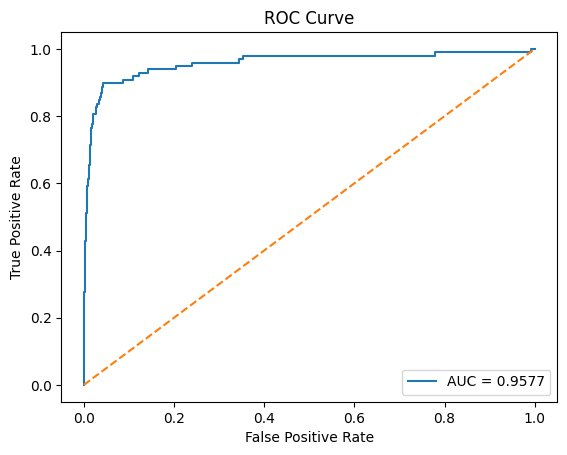

In [12]:
# 9. ROC Curve
# -------------------------------------------------------------
fpr, tpr, _ = roc_curve(y_test, mse)
plt.plot(fpr, tpr, label="AUC = {:.4f}".format(roc_auc))
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [13]:
# 10. Final Evaluation
# -------------------------------------------------------------
loss, mse_metric = autoencoder.evaluate(X_test, X_test)
print("Loss:", loss, "| MSE Metric:", mse_metric)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - loss: 0.6765 - mse: 0.6746
Loss: 0.6764764785766602 | MSE Metric: 0.6745889782905579
